In [1]:
%reset -f

In [2]:
user = "HHegde"
db = f"/Users/{user}/.data/oaklib/phenio.db"

In [3]:
%reload_ext sql
%sql sqlite:///{db}

In [4]:
%sql SELECT * FROM term_association LIMIT 2;

 * sqlite:////Users/HHegde/.data/oaklib/phenio.db
Done.


id,subject,predicate,object,evidence_type,publication,source
uuid:70269c5a-42a9-11ee-be37-31ef105c25ea,MONDO:0023659,biolink:has_phenotype,HP:0011097,ECO:0000269,PMID:31675180,infores:hpo-annotations
uuid:70269c5b-42a9-11ee-be37-31ef105c25ea,MONDO:0023659,biolink:has_phenotype,HP:0002187,ECO:0000269,PMID:31675180,infores:hpo-annotations


In [5]:
import sqlite3
import pandas as pd
from semsimian import Semsimian
from collections import Counter

In [6]:
conn = sqlite3.connect(db)
res = conn.execute("SELECT name FROM sqlite_master WHERE type='table';")
# tables = res.fetchall()

# tables

In [7]:
df_term_association = pd.read_sql_query("SELECT * FROM term_association", conn)
df_term_association.head()

,id,subject,predicate,object,evidence_type,publication,source
0,uuid:70269c5a-42a9-11ee-be37-31ef105c25ea,MONDO:0023659,biolink:has_phenotype,HP:0011097,ECO:0000269,PMID:31675180,infores:hpo-annotations
1,uuid:70269c5b-42a9-11ee-be37-31ef105c25ea,MONDO:0023659,biolink:has_phenotype,HP:0002187,ECO:0000269,PMID:31675180,infores:hpo-annotations
2,uuid:70269c5c-42a9-11ee-be37-31ef105c25ea,MONDO:0023659,biolink:has_phenotype,HP:0001518,ECO:0000269,PMID:31675180,infores:hpo-annotations
3,uuid:70269c5d-42a9-11ee-be37-31ef105c25ea,MONDO:0023659,biolink:has_phenotype,HP:0032792,ECO:0000269,PMID:31675180,infores:hpo-annotations
4,uuid:70269c5e-42a9-11ee-be37-31ef105c25ea,MONDO:0023659,biolink:has_phenotype,HP:0011451,ECO:0000269,PMID:31675180,infores:hpo-annotations


In [8]:
df_term_association['subject'].str.split(":").str[0].unique()

array(['MONDO', 'HGNC', 'WB', 'MGI', 'RGD', 'Xenbase', 'ZFIN'],
      dtype=object)

In [9]:
df_term_association['object'].str.split(":").str[0].unique()

array(['HP', 'WBPhenotype', 'MP', 'XPO', 'ZP'], dtype=object)

In [10]:
df_100 = df_term_association[df_term_association['subject'].str.startswith("MONDO:")].sample(n=4, random_state=1)
df_100 = df_100[['subject', 'predicate', 'object']]
df_100

,subject,predicate,object
217892,MONDO:0008260,biolink:has_phenotype,HP:0010047
231074,MONDO:0035763,biolink:has_phenotype,HP:0002907
149618,MONDO:0014823,biolink:has_phenotype,HP:0002650
217262,MONDO:0010674,biolink:has_phenotype,HP:0000762


In [11]:
df_100['subject'].drop_duplicates()

217892    MONDO:0008260
231074    MONDO:0035763
149618    MONDO:0014823
217262    MONDO:0010674
Name: subject, dtype: object

In [12]:
subject_object_dict = {}
for subject in df_100['subject'].drop_duplicates():
    objects = set(df_100[df_100['subject']==subject]['object'])
    subject_object_dict[subject] = objects
subject_object_dict

{'MONDO:0008260': {'HP:0010047'},
 'MONDO:0035763': {'HP:0002907'},
 'MONDO:0014823': {'HP:0002650'},
 'MONDO:0010674': {'HP:0000762'}}

In [13]:
%%time
predicates = ["rdfs:subClassOf", "BFO:0000050"]
semsimian = Semsimian(
            spo=None,
            predicates=predicates,
            pairwise_similarity_attributes=None,
            resource_path=db,
        )


CPU times: user 15.4 s, sys: 1.2 s, total: 16.6 s
Wall time: 17.1 s


In [23]:
tsps_dict = {}

for subject_1 in df_100['subject'].drop_duplicates():
    inner_dict = {}
    for subject_2 in df_100['subject'].drop_duplicates():
        inner_dict[subject_2] = semsimian.termset_pairwise_similarity(subject_object_dict[subject_1], subject_object_dict[subject_2])
        tsps_dict[subject_1] = inner_dict
        # tsps_dict[subject_1+"_"+subject_2] = semsimian.termset_pairwise_similarity(subject_object_dict[subject_1], subject_object_dict[subject_2])

In [24]:
tsps_dict

{'MONDO:0008260': {'MONDO:0008260': {'subject_termset': [{'HP:0010047': {'id': 'HP:0010047',
      'label': 'Short 5th metacarpal (HPO)'}}],
   'object_termset': [{'HP:0010047': {'id': 'HP:0010047',
      'label': 'Short 5th metacarpal (HPO)'}}],
   'subject_best_matches': {'HP:0010047': {'match_source': 'HP:0010047',
     'match_source_label': 'Short 5th metacarpal (HPO)',
     'match_target': 'HP:0010047',
     'match_target_label': 'Short 5th metacarpal (HPO)',
     'score': '18.008877205969117'},
    'similarity': {'HP:0010047': {'ancestor_id': 'HP:0010047',
      'ancestor_information_content': '18.008877205969117',
      'ancestor_label': 'Short 5th metacarpal (HPO)',
      'cosine_similarity': 'NaN',
      'jaccard_similarity': '1',
      'object_id': 'HP:0010047',
      'phenodigm_score': '4.243686746918193',
      'subject_id': 'HP:0010047'}}},
   'object_best_matches': {'HP:0010047': {'match_source': 'HP:0010047',
     'match_source_label': 'Short 5th metacarpal (HPO)',
     

In [14]:

subject_prefixes = ["MGI:"]
# object_terms = set(df_100['object'].drop_duplicates())
assoc_predicate = {"biolink:has_phenotype"}
include_similarity_object = True
limit = 50


In [15]:
%%time

search_type = "flat"
flat_result = {}
for subj, obj in subject_object_dict.items():
    flat_result[subj] = semsimian.associations_search(
                assoc_predicate,
                set(obj),
                include_similarity_object,
                search_type,
                None,
                subject_prefixes,
                limit,
            )

Using cache! "MGI:biolink:has_phenotypeflat"
Using cache! "MGI:biolink:has_phenotypeflat"
Using cache! "MGI:biolink:has_phenotypeflat"
Using cache! "MGI:biolink:has_phenotypeflat"
Using cache! "MGI:biolink:has_phenotypeflat"
Using cache! "MGI:biolink:has_phenotypeflat"
Using cache! "MGI:biolink:has_phenotypeflat"
Using cache! "MGI:biolink:has_phenotypeflat"
Using cache! "MGI:biolink:has_phenotypeflat"
Using cache! "MGI:biolink:has_phenotypeflat"
Using cache! "MGI:biolink:has_phenotypeflat"
Using cache! "MGI:biolink:has_phenotypeflat"
Using cache! "MGI:biolink:has_phenotypeflat"
Using cache! "MGI:biolink:has_phenotypeflat"
Using cache! "MGI:biolink:has_phenotypeflat"
Using cache! "MGI:biolink:has_phenotypeflat"
Using cache! "MGI:biolink:has_phenotypeflat"
Using cache! "MGI:biolink:has_phenotypeflat"
Using cache! "MGI:biolink:has_phenotypeflat"
Using cache! "MGI:biolink:has_phenotypeflat"
Using cache! "MGI:biolink:has_phenotypeflat"
Using cache! "MGI:biolink:has_phenotypeflat"
Using cach

In [16]:
len(flat_result)

100

In [17]:
%%time

search_type = "full"
full_result = {}
for subj, obj in subject_object_dict.items():
    full_result[subj] = semsimian.associations_search(
                assoc_predicate,
                set(obj),
                include_similarity_object,
                search_type,
                None,
                subject_prefixes,
                limit,
            )

Using cache! "MGI:biolink:has_phenotypefull"
Using cache! "MGI:biolink:has_phenotypefull"
Using cache! "MGI:biolink:has_phenotypefull"
Using cache! "MGI:biolink:has_phenotypefull"
Using cache! "MGI:biolink:has_phenotypefull"
Using cache! "MGI:biolink:has_phenotypefull"
Using cache! "MGI:biolink:has_phenotypefull"
Using cache! "MGI:biolink:has_phenotypefull"
Using cache! "MGI:biolink:has_phenotypefull"
Using cache! "MGI:biolink:has_phenotypefull"
Using cache! "MGI:biolink:has_phenotypefull"
Using cache! "MGI:biolink:has_phenotypefull"
Using cache! "MGI:biolink:has_phenotypefull"
Using cache! "MGI:biolink:has_phenotypefull"
Using cache! "MGI:biolink:has_phenotypefull"
Using cache! "MGI:biolink:has_phenotypefull"
Using cache! "MGI:biolink:has_phenotypefull"
Using cache! "MGI:biolink:has_phenotypefull"
Using cache! "MGI:biolink:has_phenotypefull"
Using cache! "MGI:biolink:has_phenotypefull"
Using cache! "MGI:biolink:has_phenotypefull"
Using cache! "MGI:biolink:has_phenotypefull"
Using cach

In [18]:
len(full_result)

100

In [19]:
%%time

search_type = "hybrid"
hybrid_result = {}
for subj, obj in subject_object_dict.items():
    hybrid_result[subj] = semsimian.associations_search(
                assoc_predicate,
                set(obj),
                include_similarity_object,
                search_type,
                None,
                subject_prefixes,
                limit,
            )

Using cache! "MGI:biolink:has_phenotypeflat"
Using cache! "MGI:biolink:has_phenotypefull"
Using cache! "MGI:biolink:has_phenotypeflat"
Using cache! "MGI:biolink:has_phenotypefull"
Using cache! "MGI:biolink:has_phenotypeflat"
Using cache! "MGI:biolink:has_phenotypefull"
Using cache! "MGI:biolink:has_phenotypeflat"
Using cache! "MGI:biolink:has_phenotypefull"
Using cache! "MGI:biolink:has_phenotypeflat"
Using cache! "MGI:biolink:has_phenotypefull"
Using cache! "MGI:biolink:has_phenotypeflat"
Using cache! "MGI:biolink:has_phenotypefull"
Using cache! "MGI:biolink:has_phenotypeflat"
Using cache! "MGI:biolink:has_phenotypefull"
Using cache! "MGI:biolink:has_phenotypeflat"
Using cache! "MGI:biolink:has_phenotypefull"
Using cache! "MGI:biolink:has_phenotypeflat"
Using cache! "MGI:biolink:has_phenotypefull"
Using cache! "MGI:biolink:has_phenotypeflat"
Using cache! "MGI:biolink:has_phenotypefull"
Using cache! "MGI:biolink:has_phenotypeflat"
Using cache! "MGI:biolink:has_phenotypefull"
Using cach

In [20]:
len(hybrid_result)

100

In [29]:
def get_search_terms_for_input_term(dictionary:dict):
    result_dict = {}
    for k, v in dictionary.items():
        result_dict[k] = [curie for _,_,curie in v]
    return result_dict
        

In [31]:
full_result_terms = get_search_terms_for_input_term(full_result)
flat_result_terms = get_search_terms_for_input_term(flat_result)
hybrid_result_terms = get_search_terms_for_input_term(hybrid_result)

In [59]:
def get_overlap(dict1, dict2):
    input_term_overlap = {}
    for term, result in dict1.items():
        common = set(result).intersection(set(dict2[term]))
        total = len(set(dict2[term]) | set(result))
        overlap = len(common) / total * 100
        input_term_overlap[term] = overlap
    return input_term_overlap
    

In [67]:
# input_term_full_flat_overlap = get_overlap(full_result_terms, flat_result_terms)
input_term_full_hybrid_overlap = get_overlap(full_result_terms, hybrid_result_terms)
input_term_full_flat_overlap = get_overlap(full_result_terms, flat_result_terms)
input_term_flat_hybrid_overlap = get_overlap(flat_result_terms, hybrid_result_terms)

input_term_flat_hybrid_overlap
# print(len(set(full_result_terms['MGI:1261425']).intersection(set(full_result_terms['MGI:1261425']))))

{'MGI:1261425': 14.942528735632186,
 'MGI:1858212': 31.57894736842105,
 'MGI:109207': 61.29032258064516,
 'MGI:98475': 11.11111111111111,
 'MGI:97512': 25.0,
 'MGI:88291': 33.33333333333333,
 'MGI:1914362': 49.25373134328358,
 'MGI:1924285': 7.526881720430108,
 'MGI:2385958': 8.695652173913043,
 'MGI:1313275': 17.647058823529413,
 'MGI:2177178': 19.047619047619047,
 'MGI:98973': 13.636363636363635,
 'MGI:1341163': 4.166666666666666,
 'MGI:97311': 35.13513513513514,
 'MGI:88258': 53.84615384615385,
 'MGI:1915325': 26.582278481012654,
 'MGI:96083': 25.0,
 'MGI:95808': 51.515151515151516,
 'MGI:104779': 9.89010989010989,
 'MGI:104673': 29.87012987012987,
 'MGI:1321392': 75.43859649122807,
 'MGI:97348': 56.25,
 'MGI:1339999': 85.18518518518519,
 'MGI:88145': 35.13513513513514,
 'MGI:1098280': 44.927536231884055,
 'MGI:1891740': 2.0408163265306123,
 'MGI:1346872': 14.942528735632186,
 'MGI:105098': 35.13513513513514,
 'MGI:97503': 38.88888888888889,
 'MGI:2673128': 36.986301369863014,
 'MGI

### Plot params

In [88]:
import matplotlib.pyplot as plt



def plot_graph(data, title):
    # Create lists for the plot
    keys = list(data.keys())
    values = list(data.values())
    
    # Create a bar chart
    plt.figure(figsize=(20,10))  # Increase the size as needed
    bars = plt.bar(range(len(data)), values, tick_label=keys)
    
    # Rotate the x-axis labels so they don't overlap
    plt.xticks(rotation=90)
    
    # Add title and labels
    plt.title(title)
    plt.xlabel('Keys')
    plt.ylabel('Values')

    # Loop over the bars and add the value on top
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom', rotation=45)  # va: vertical alignment
    
    # Show the plot
    plt.show()


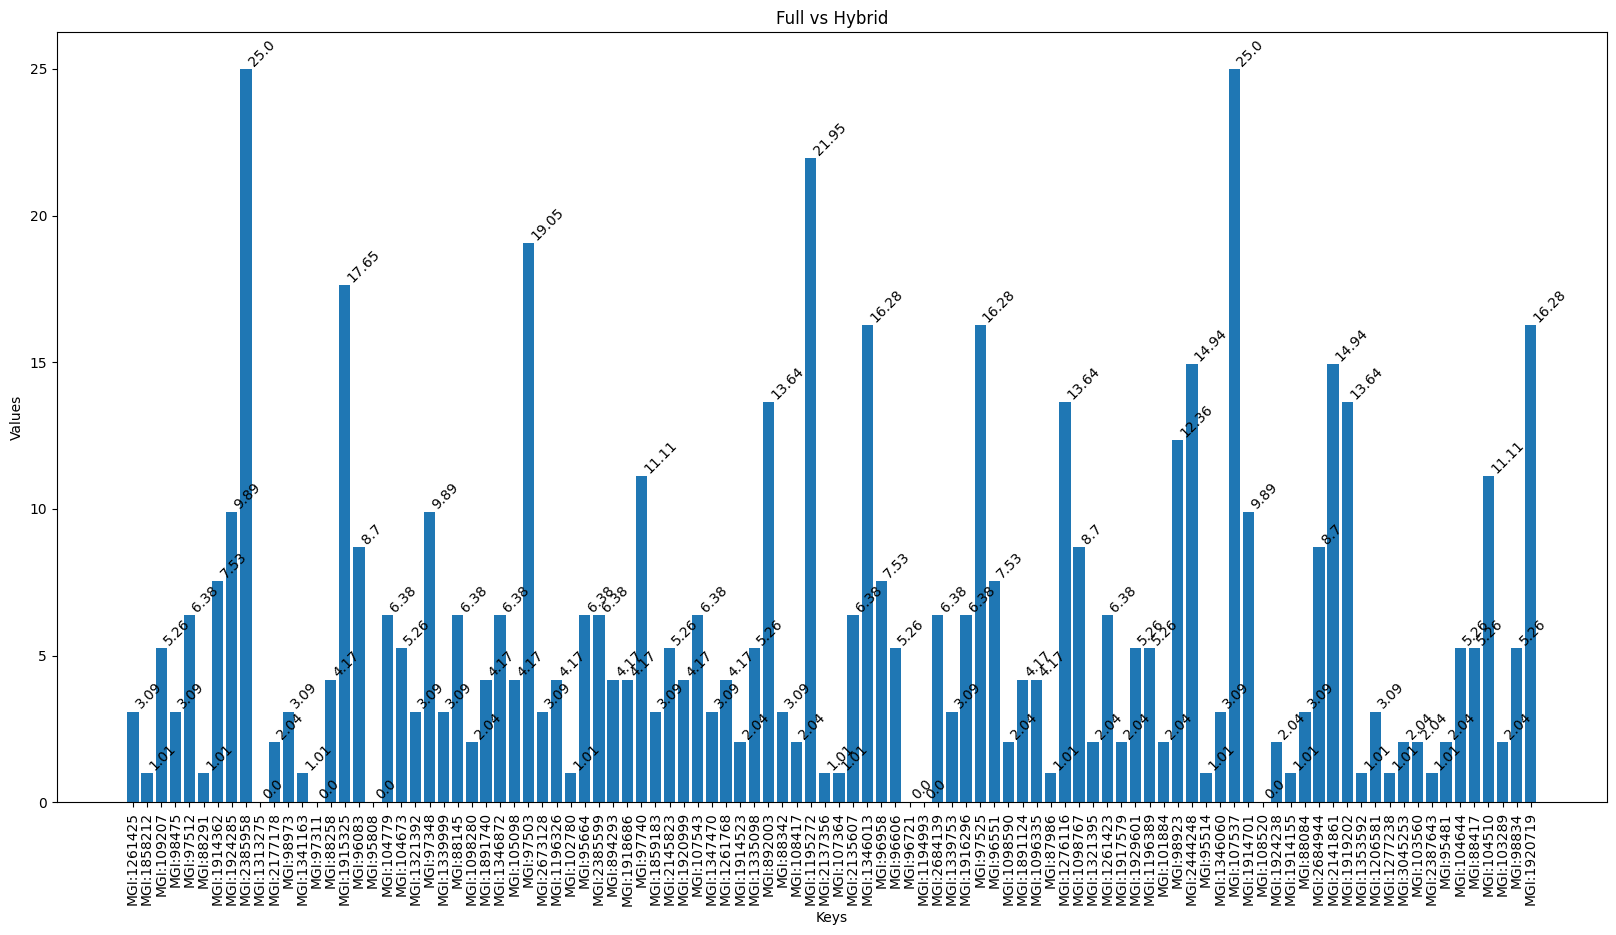

In [89]:

plot_graph(input_term_full_hybrid_overlap, "Full vs Hybrid")

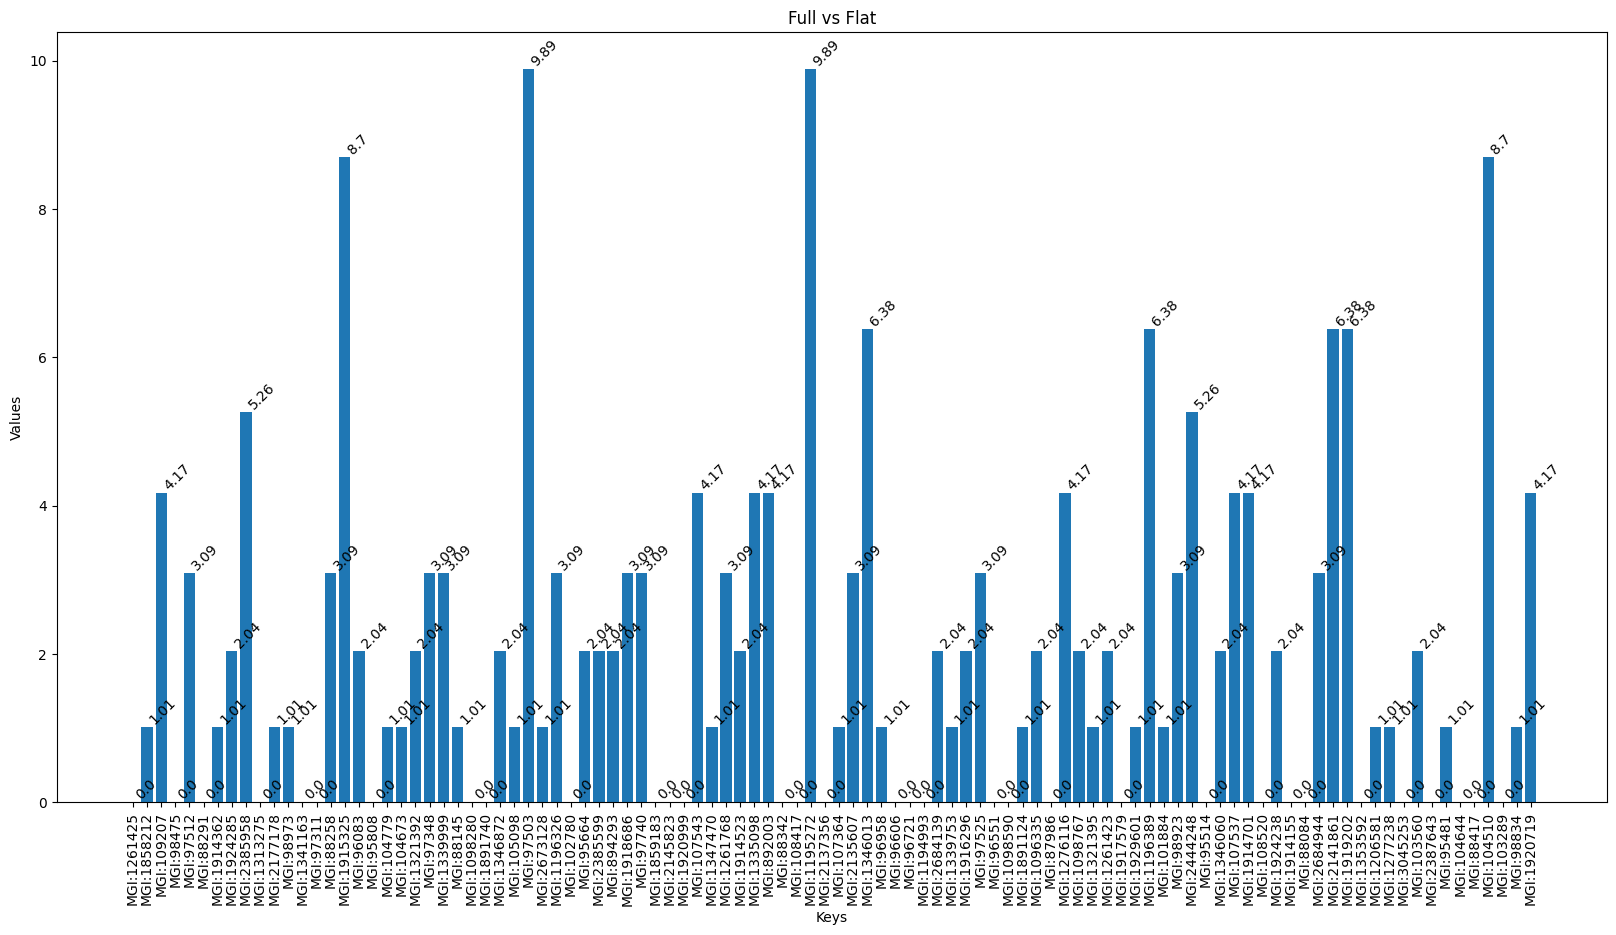

In [90]:

plot_graph(input_term_full_flat_overlap, "Full vs Flat")

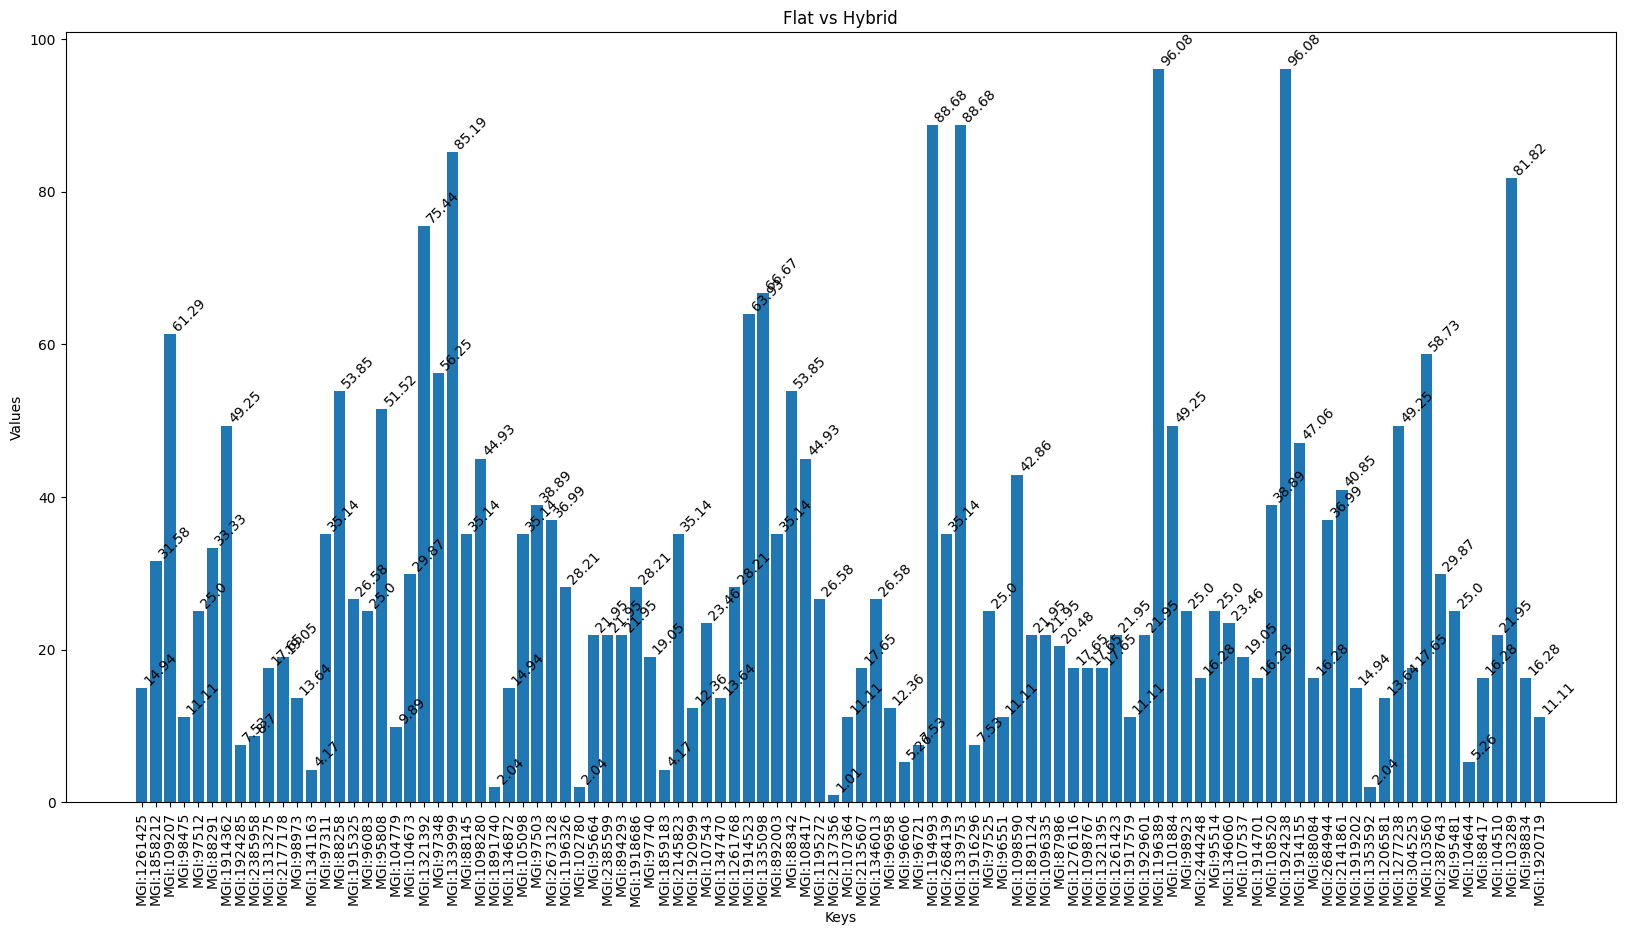

In [91]:

plot_graph(input_term_flat_hybrid_overlap, "Flat vs Hybrid")